In [1]:
from itertools import combinations, combinations_with_replacement

import graspologic as gp
import hyppo
import matplotlib
import matplotlib.cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
from hyppo.ksample import MANOVA, KSample
from joblib import Parallel, delayed
from matplotlib.transforms import Bbox
from scipy.spatial.distance import squareform
from scipy.stats import kruskal
from seaborn.utils import relative_luminance
from sklearn.preprocessing import LabelEncoder
from statsmodels.stats.multitest import multipletests

from pkg.data import (
    GENOTYPES,
    HEMISPHERES,
    SUB_STRUCTURES,
    SUPER_STRUCTURES,
    load_fa_corr,
    load_vertex_df,
    load_vertex_metadata,
    load_volume,
    load_volume_corr,
)
from pkg.inference import run_ksample, run_pairwise
from pkg.plot import plot_heatmaps, plot_pairwise
from pkg.utils import rank, squareize

matplotlib.rcParams["font.family"] = "monospace"

import warnings

warnings.simplefilter(action="ignore")

In [2]:
# Load the data

volume_correlations, labels = load_volume_corr()

meta = load_vertex_df()

volume_correlations = np.array([rank(v) for v in np.abs(volume_correlations)])

# K-sample latent position distribution test


## Embed the data simultaneously using Omnibus embedding

The purpose of omnibus embedding is to obtain a low dimensional representation of the three correlation matrices such that the embedded correlation matrices can be compared to each other in a meaningful way {cite:p}Athreya2018-zp,ase-consistency-1,ase-consistency-2,ase-consistency-3. The embedding provides a low dimensional vector per region of the brain for each correlation matrix, resulting in a  matrix per genotype where  is the "embedding dimension" and . The resulting vectors per region is called a latent positions of a vertex. Omnibus embedding is similar to the idea of using PCA on data to get dataset with reduced number of features.

In [5]:
latents = gp.embed.OmnibusEmbed().fit_transform(volume_correlations)

## Running K-sample on all vertices

In [8]:
ksample = KSample("dcorr")

ksample.test(*latents, auto=False, workers=-1)

IndependenceTestOutput(stat=0.0909769965981636, pvalue=0.000999000999000999)

### Hierachical

In [9]:
vertex_hemispheres = meta.Hemisphere.values
vertex_structures = meta.Level_1.values
vertex_hemisphere_structures = (meta.Hemisphere + "-" + meta.Level_1).values
vertex_hemisphere_substructures = (
    meta.Hemisphere + "-" + meta.Level_1 + "-" + meta.Level_2
).values

In [20]:
res = []

for labels in [
    vertex_hemispheres,
    vertex_structures,
    vertex_hemisphere_structures,
    vertex_hemisphere_substructures,
]:
    tmp = []
    for lab in np.unique(labels):
        idx = labels == lab

        if idx.sum() > 3:
            ksample = KSample("dcorr")
            stat, pval = ksample.test(*latents[:, idx, :], auto=False, workers=-1)
        else:
            pval = 1

        tmp.append(pval)

    res.append(tmp)

In [31]:
res = [[0.000999000999000999]] + res

In [32]:
corrected = multipletests(
    [j for i in res for j in i],
)

In [91]:
c = list(np.log10(corrected[1]))
s = []

for length in [len(i) for i in res]:
    t = []
    for j in range(length):
        t.append(c.pop(0))
    while len(t) < 30:
        t.append(np.nan)
    s.append(t)

s = np.array(s)

In [108]:
c = np.log10(list(corrected[1]))

kwags = dict(
    cmap="RdBu",
    square=True,
    cbar=False,
    vmax=c.max(),
    vmin=c.min(),
    center=0,
    xticklabels=[],
)

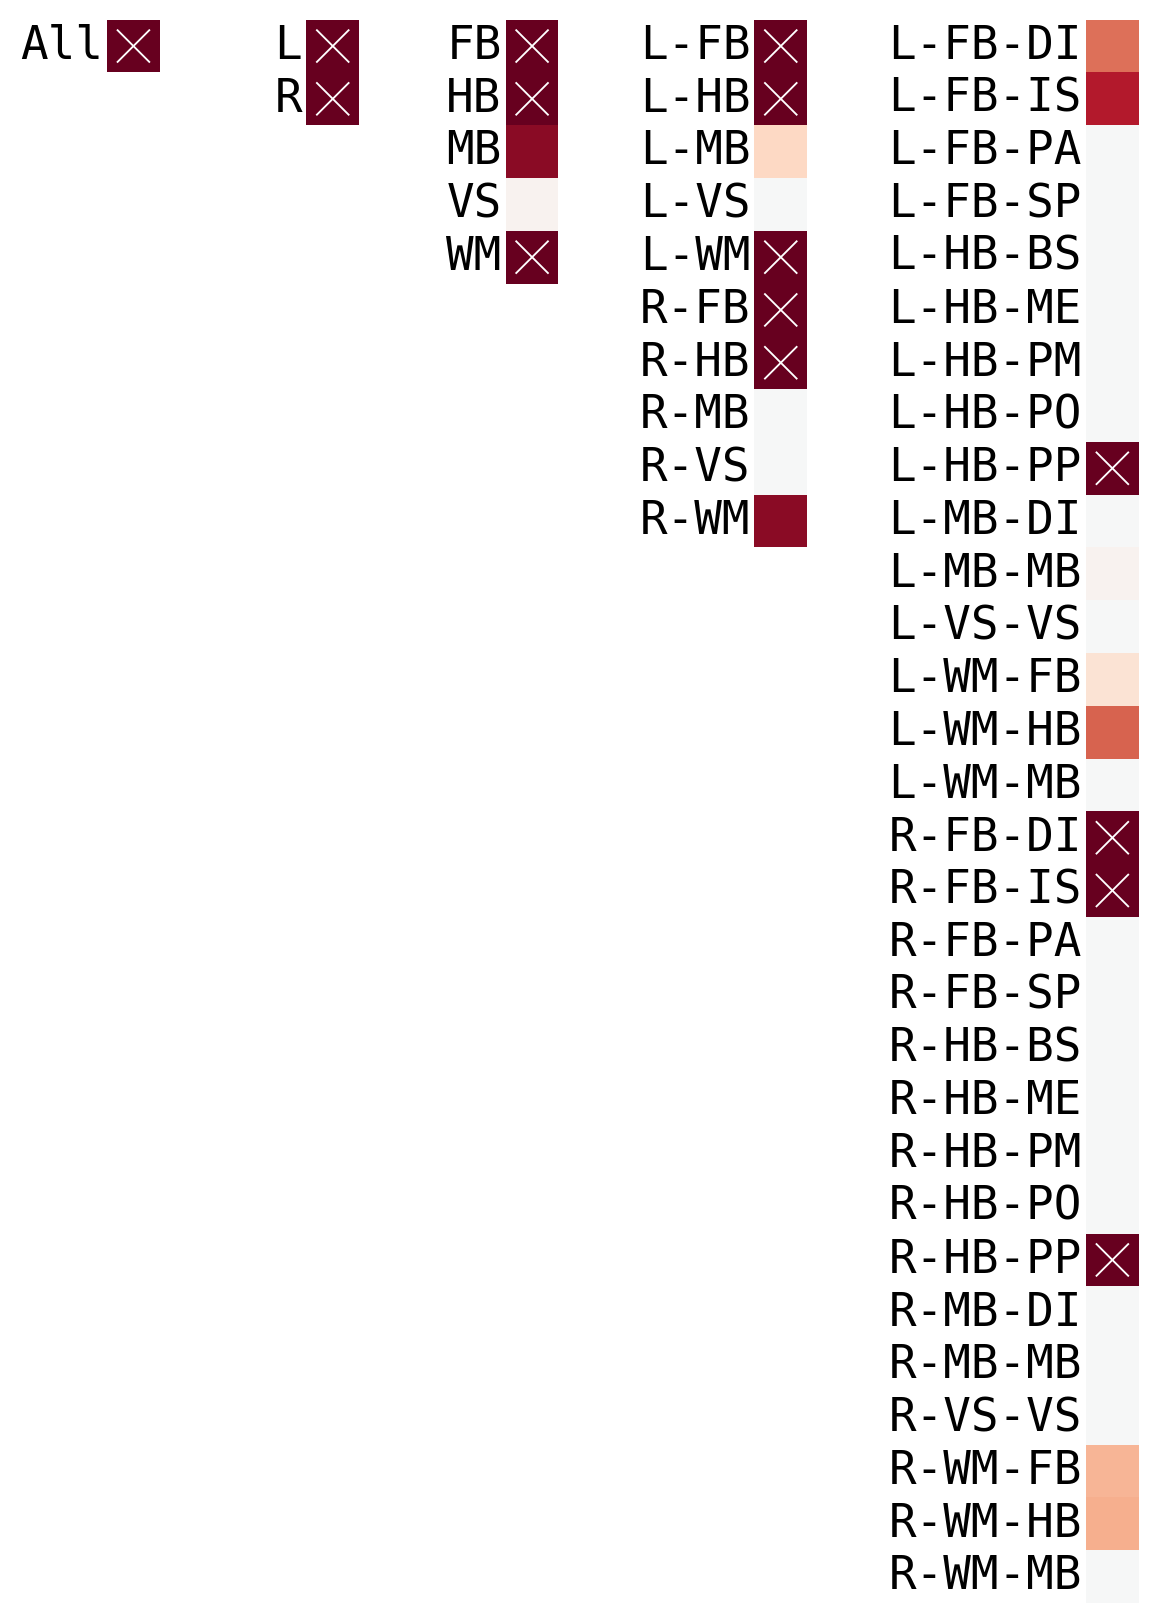

In [134]:
sns.set_context("talk")


fig, ax = plt.subplots(figsize=(6, 8), ncols=5, dpi=200, constrained_layout=True)

for idx, (data, labs) in enumerate(
    zip(
        s,
        [
            ["All"],
            vertex_hemispheres,
            vertex_structures,
            vertex_hemisphere_structures,
            vertex_hemisphere_substructures,
        ],
    )
):
    im = sns.heatmap(s[[idx]].T, **kwags, ax=ax[idx], yticklabels=np.unique(labs))
    ax[idx].tick_params(
        axis="y",
        labelrotation=0,
        pad=0.5,
        length=1,
        left=False,
    )

    colors = im.get_children()[0].get_facecolors()
    pad = 0.2

    for jdx, row in enumerate(s[idx]):
        i, j = np.unravel_index(jdx, (30, 1))

        # REF: seaborn heatmap
        lum = relative_luminance(colors[jdx])
        text_color = ".15" if lum > 0.408 else "w"
        lw = 20 / 30

        if row <= np.log10(0.05):
            xs = [j + pad, j + 1 - pad]
            ys = [i + pad, i + 1 - pad]
            ax[idx].plot(xs, ys, color=text_color, linewidth=lw)
            xs = [j + 1 - pad, j + pad]
            ys = [i + pad, i + 1 - pad]
            ax[idx].plot(xs, ys, color=text_color, linewidth=lw)